In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data23668


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

In [45]:
# !git clone https://github.com/mmmmmmiracle/paddle_seven_days.git
! cp *.*

Cloning into 'paddle_seven_days'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
Checking connectivity... done.


In [3]:

!cd /home/aistudio/data/data23668 && unzip -qo Dataset.zip
!cd /home/aistudio/data/data23668/Dataset && rm -f */.DS_Store # 删除无关文件 


In [33]:
import os
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers
from multiprocessing import cpu_count
from paddle.fluid.dygraph import Pool2D,Conv2D
from paddle.fluid.dygraph import Linear,Sequential,BatchNorm, CosineDecay
import albumentations as albu

In [35]:
# !pip install albumentations

In [34]:

# 生成图像列表
data_path = '/home/aistudio/data/data23668/Dataset'
character_folders = os.listdir(data_path)
# print(character_folders)
if(os.path.exists('./train_data.list')):
    os.remove('./train_data.list')
if(os.path.exists('./test_data.list')):
    os.remove('./test_data.list')
    
for character_folder in character_folders:
    
    with open('./train_data.list', 'a') as f_train:
        with open('./test_data.list', 'a') as f_test:
            if character_folder == '.DS_Store':
                continue
            character_imgs = os.listdir(os.path.join(data_path,character_folder))
            count = 0 
            for img in character_imgs:
                if img =='.DS_Store':
                    continue
                if count%10 == 0:
                    f_test.write(os.path.join(data_path,character_folder,img) + '\t' + character_folder + '\n')
                else:
                    f_train.write(os.path.join(data_path,character_folder,img) + '\t' + character_folder + '\n')
                count +=1
print('列表已生成')


列表已生成


In [36]:
def ricap(X, y):
    '''
        功能：图像增强，Random Image Cropping and Patching
        参数：
            X：batch imgs
            y: batch labels
        超参：
            beta: beta分布的alpha和beta参数，这个可以自己设置，并观察结果
        引用：
            Data Augmentation using Random Image Cropping and Patching for Deep CNNs(https://arxiv.org/abs/1811.09030v1)
    '''
    beta = 0.1
    I_x, I_y = X.shape[2:]
    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]
    cropped_images = {}
    c_ = {}
    W_ = {}
    for k in range(4):
        index = np.arange(X.shape[0])
        np.random.shuffle(index)
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = X[index][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        c_[k] = y[index]
        W_[k] = w_[k] * h_[k] / (I_x * I_y)
    patched_images = np.concatenate(
        (np.concatenate((cropped_images[0], cropped_images[1]), 2),
        np.concatenate((cropped_images[2], cropped_images[3]), 2)), 3)
    return patched_images, y, W_, c_

def mixup(X, y):
    '''
        功能：图像增强，mixup
        参数：
            X：batch imgs
            y: batch labels
        超参：
            beta: beta分布的alpha和beta参数，这个可以自己设置，并观察结果
        引用：
            mixup: Beyond Empirical Risk Minimization(https://arxiv.org/abs/1710.09412)
    '''
    mixup_alpha = 0.1
    seed = np.random.beta(mixup_alpha, mixup_alpha)
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    images_a, images_b = X, X[index]
    labels_a, labels_b = y, y[index]
    mixed_images = seed * images_a + (1 - seed) * images_b
    return mixed_images, labels_a, labels_b, seed


a = np.zeros((32, 3, 128, 128))
b = np.random.randint(0,10,32)
mixup(a,b)[2]

array([7, 6, 1, 9, 5, 8, 9, 3, 2, 2, 8, 5, 4, 7, 7, 6, 5, 4, 3, 3, 3, 9,
       2, 4, 7, 3, 2, 4, 2, 8, 3, 3])

In [37]:
# 定义训练集和测试集的reader
FIG_SIZE = 100
# def data_mapper(sample):
#     img, label = sample
#     img = Image.open(img)
#     img = img.resize((FIG_SIZE, FIG_SIZE), Image.ANTIALIAS)
#     img = np.array(img).astype('float32')
#     img = img.transpose((2, 0, 1))
#     img = img/255.0
#     return img, label

# def data_reader(data_list_path):
#     def reader():
#         with open(data_list_path, 'r') as f:
#             lines = f.readlines()
#             for line in lines:
#                 img, label = line.split('\t')
#                 yield img, int(label)
#     return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), 512)
 
def train_aug(p=0.5):
    return albu.Compose([
        # albu.RandomResizedCrop(FIG_SIZE, FIG_SIZE,p=0.5),
        albu.Cutout(p=0.5),   
        # albu.Normalize(),
    ], p=p)

def test_aug():
    return albu.Compose([
        # albu.Normalize(),
    ], p=1)

# 定义训练集和测试集的reader
def train_data_mapper(sample):
    img, label = sample
    img = Image.open(img)
    img = img.resize((FIG_SIZE, FIG_SIZE), Image.ANTIALIAS)
    
    r1 = random.random()
    if r1 > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    # 随机垂直翻转
    r2 = random.random()
    if r2 > 0.5:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
    # 随机角度翻转
    r3 = random.randint(-3, 3)
    img = img.rotate(r3, expand=False)

    img = np.array(img).astype(np.float32)
    img = img / 255.0

    # aug = train_aug()
    # img = aug(**{'image':img})['image']

    img = img.transpose((2, 0, 1))
    return img, int(label)

def test_data_mapper(sample):
    img, label = sample
    img = Image.open(img)
    img = img.resize((FIG_SIZE, FIG_SIZE), Image.ANTIALIAS)
    
    img = np.array(img).astype(np.float32)
    img = img / 255.0

    # aug = test_aug()
    # img = aug(**{'image':img})['image']

    img = img.transpose((2, 0, 1))
    return img, int(label)

def data_reader(data_list_path, is_train=True):
    def reader():
        with open(data_list_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                img, label = line.split('\t')
                yield img, int(label)
    data_mapper = None
    if is_train:
        data_mapper = train_data_mapper
    else:
        data_mapper = test_data_mapper
    return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), 51200)


In [38]:
# 用于训练的数据提供器
train_reader = paddle.batch(reader=paddle.reader.shuffle(reader=data_reader('./train_data.list'), buf_size=25600), batch_size=32)
# 用于测试的数据提供器
test_reader = paddle.batch(reader=data_reader('./test_data.list',False), batch_size=32) 


In [39]:
#定义DNN网络
#ResNet18
class Residual(fluid.dygraph.Layer):
    #可以设定输出通道数、是否使用额外的1x1卷积层来修改通道数以及卷积层的步幅。
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = Conv2D(in_channels, out_channels, 3, padding=1, stride=stride)
        self.conv2 = Conv2D(out_channels, out_channels, 3, padding=1)
        if use_1x1conv:
            self.conv3 = Conv2D(in_channels, out_channels, 1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = BatchNorm(out_channels, act='relu')
        self.bn2 = BatchNorm(out_channels)

    def forward(self, X):
        Y = self.bn1(self.conv1(X))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return layers.relu(Y + X)

class ResBlock(fluid.dygraph.Layer):
    def __init__(self, in_channels, out_channels, num_rediduals, first_block=False):
        super(ResBlock, self).__init__()
        if first_block:
            assert in_channels == out_channels # 第一个模块的通道数同输入通道数一致
        block = []
        for i in range(num_rediduals):
            block.append(Residual(in_channels, out_channels, use_1x1conv=not first_block, stride=2-int(first_block)))
            in_channels = out_channels
        self.resi_block = Sequential(*block)

    def forward(self, X):
        return self.resi_block(X)

class ResNet(fluid.dygraph.Layer):
    def __init__(self, *, channels, fig_size, num_class):
        super(ResNet, self).__init__()
        self.conv = Sequential(
            Conv2D(channels, 32, 7, 2, 3),
            BatchNorm(32, act='relu'),
        )
        self.res_block_arch = [(32, 32, 2, True), (32, 64, 2), (64, 128, 2), (128, 256, 2)]
        self.res_blocks = Sequential()
        for i, arch in enumerate(self.res_block_arch):
            self.res_blocks.add_sublayer(f'res_block_{i+1}', ResBlock(*arch))
        self.global_avg_pool = Pool2D(pool_type='avg',global_pooling=True)
        self.fc =Linear(256, num_class, act='softmax')

    def forward(self, X):
        conv_features = layers.pool2d(self.conv(X),2,'max',2)
        res_features = self.res_blocks(conv_features)
        global_avg_pool = self.global_avg_pool(res_features)
        global_avg_pool = layers.flatten(global_avg_pool)
        y = self.fc(global_avg_pool)
        return y

In [40]:
EPOCH = 50
#用动态图进行训练
train_losses = []
train_accs = []
with fluid.dygraph.guard():
    # model=MyDNN() #模型实例化
    model = ResNet(channels=3, fig_size=FIG_SIZE, num_class=10)
    model.train() #训练模式
    opt=fluid.optimizer.SGDOptimizer(
        learning_rate=CosineDecay(0.0125, EPOCH, EPOCH), 
        parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.

    epochs_num=EPOCH #迭代次数
    
    for pass_num in range(epochs_num):
        
        n = 0
        L = 0
        accuracy = 0
        for batch_id,data in enumerate(train_reader()):
            
            images=np.array([x[0].reshape(3,FIG_SIZE,FIG_SIZE) for x in data],np.float32)
            
            labels = np.array([x[1] for x in data]).astype('int64')
            # images, labels, W_, c_ = ricap(images, labels)  # ricap data aug
            # images, labels_a, labels_b, seed = mixup(images, labels)
            # print(images.shape, labels.shape, W_, c_)
            labels = labels[:, np.newaxis]
            # print(images.shape)
            image=fluid.dygraph.to_variable(images)
            label=fluid.dygraph.to_variable(labels)
            predict=model(image)#预测
            # print(predict)
            loss=fluid.layers.cross_entropy(predict,label)
            # print(np.sum(predict.numpy()[0]))
            # loss = layers.sum([W_[k] * fluid.layers.cross_entropy(predict, layers.unsqueeze(fluid.dygraph.to_variable(c_[k]),[1])) for k in range(4)])  # ricap loss
            # loss = seed * fluid.layers.cross_entropy(predict, fluid.dygraph.to_variable(labels_a)) + (1 - seed) * fluid.layers.cross_entropy(predict, fluid.dygraph.to_variable(labels_b))
            # print(predict.numpy())
            avg_loss=fluid.layers.mean(loss)#获取loss值
            acc=fluid.layers.accuracy(predict,label)#计算精度
            # acc = layers.sum([W_[k] * fluid.layers.accuracy(predict, layers.unsqueeze(fluid.dygraph.to_variable(c_[k]),[1])) for k in range(4)]) # ricap acc
            # acc = seed * fluid.layers.accuracy(predict, layers.unsqueeze(fluid.dygraph.to_variable(labels_a), axes=[1])) + (1 - seed) * fluid.layers.accuracy(predict, layers.unsqueeze(fluid.dygraph.to_variable(labels_b),axes=[1]))
            
            # if batch_id!=0 and batch_id%50==0:
            #     print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,avg_loss.numpy(),acc.numpy()))
            #     train_losses.append(avg_loss.numpy())
            #     train_accs.append(acc.numpy())
            n += 1
            L += avg_loss.numpy()
            accuracy += acc.numpy()
            
            avg_loss.backward()
            opt.minimize(avg_loss)
            model.clear_gradients()

        print("train_pass:{},train_loss:{},train_acc:{}".format(pass_num,L/n,accuracy / n))
        train_losses.append(L/n)
        train_accs.append(accuracy/n) 
    fluid.save_dygraph(model.state_dict(),'MyDNN')#保存模型
 

train_pass:0,train_loss:[2.8470898],train_acc:[0.18080358]
train_pass:1,train_loss:[1.7136889],train_acc:[0.40509543]
train_pass:2,train_loss:[1.2842858],train_acc:[0.55849755]
train_pass:3,train_loss:[0.94704664],train_acc:[0.67302954]
train_pass:4,train_loss:[0.76377386],train_acc:[0.7339132]
train_pass:5,train_loss:[0.6521646],train_acc:[0.7814809]
train_pass:6,train_loss:[0.53824836],train_acc:[0.81149936]
train_pass:7,train_loss:[0.45140898],train_acc:[0.851601]
train_pass:8,train_loss:[0.39780933],train_acc:[0.8613762]
train_pass:9,train_loss:[0.38118583],train_acc:[0.869843]
train_pass:10,train_loss:[0.3578642],train_acc:[0.8784637]
train_pass:11,train_loss:[0.25195798],train_acc:[0.9194889]
train_pass:12,train_loss:[0.24662],train_acc:[0.9201046]
train_pass:13,train_loss:[0.22872332],train_acc:[0.9254926]
train_pass:14,train_loss:[0.21304429],train_acc:[0.9324969]
train_pass:15,train_loss:[0.17837381],train_acc:[0.9433498]
train_pass:16,train_loss:[0.18178277],train_acc:[0.9415

In [ ]:
# print(train_losses)

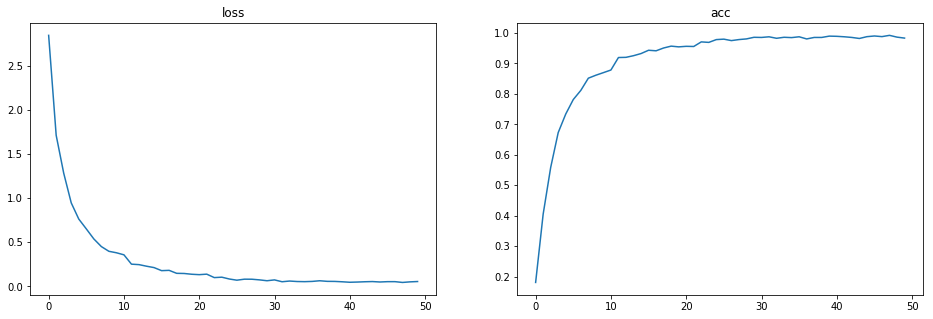

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(train_losses)
plt.title('loss')
plt.subplot(122)
plt.plot(train_accs)
plt.title('acc')
plt.savefig('random_flip.png')
plt.show()

In [42]:
#模型校验
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyDNN')
    model = ResNet(channels=3, fig_size=FIG_SIZE, num_class=10)
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    for batch_id,data in enumerate(test_reader()):#测试集
        images=np.array([x[0].reshape(3,FIG_SIZE,FIG_SIZE) for x in data],np.float32)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]

        image=fluid.dygraph.to_variable(images)
        label=fluid.dygraph.to_variable(labels)
        
        predict=model(image)       
        acc=fluid.layers.accuracy(predict,label)
        accs.append(acc.numpy()[0])
        print('current test batch accuracy',acc.numpy())
        avg_acc = np.mean(accs)
    print(avg_acc)

current test batch accuracy [0.9375]
current test batch accuracy [0.9375]
current test batch accuracy [0.9375]
current test batch accuracy [0.96875]
current test batch accuracy [0.96875]
current test batch accuracy [0.8125]
current test batch accuracy [0.7777778]
0.90575397


# 实验结果

| model | data aug | acc |
| -------- | -------- | -------- |
| resnet18 | RANDOM FLIP     | 0.90575397  |
| resnet18 | RICAP     | 0.97172624  |
| resnet18 | CUTOUT     | 0.91914684  |
| resnet18 | MIXUP     | 0.88789684  |
| resnet18 | MIXUP + CUTOUT   | 0.9236111  |

> 实验中优化器选的是SGDOptimizer(通常SGD能达到较好的后期效果，但是收敛速度较慢)，学习率调整策略是CosineDecay,初始化lr = 0.1 * (32 / 256), 32为我设置的batch_size 大小

(3, 100, 100)
5


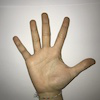

In [ ]:
#读取预测图像，进行预测

def load_image(path):
    img = Image.open(path)
    img = img.resize((100, 100), Image.ANTIALIAS)
    img = np.array(img).astype('float32')
    img = img.transpose((2, 0, 1))
    img = img/255.0
    print(img.shape)
    return img

#构建预测动态图过程
with fluid.dygraph.guard():
    infer_path = '手势.JPG'
    model=ResNet(channels=3, fig_size=FIG_SIZE, num_class=10)#模型实例化
    model_dict,_=fluid.load_dygraph('MyDNN')
    model.load_dict(model_dict)#加载模型参数
    model.eval()#评估模式
    infer_img = load_image(infer_path)
    infer_img=np.array(infer_img).astype('float32')
    infer_img=infer_img[np.newaxis,:, : ,:]
    infer_img = fluid.dygraph.to_variable(infer_img)
    result=model(infer_img)
    display(Image.open('手势.JPG'))
    print(np.argmax(result.numpy()))